In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("C:\\Users\\DELL8\\OneDrive\\Pictures\\OptimalPolicy_angletol45.csv")

### **Dataset Description **

#### **Dataset Overview**
The dataset consists of **1,140 rows** and **11 columns** and appears to represent state-action data for a reinforcement learning environment. It includes state variables (`state_x`, `state_y`), action decisions (`move_dir`, `throw_dir`, `Action`), and numerical movement information.

#### **Columns Description**
1. **`Unnamed: 0`**: Index column (not needed for analysis).  
2. **`state_x` & `state_y`**: Represent the current state coordinates.  
3. **`move_dir`**: Indicates the movement direction (categorical).  
4. **`throw_dir`**: Represents the direction of a throw (categorical).  
5. **`Action`**: The action taken at a particular state (categorical).  
6. **`move_x` & `move_y`**: Represent numerical movement values in the x and y directions.  
7. **`throw_dir_2`**: Encodes additional directional information.  
8. **`u` & `v`**: Numeric features that likely represent velocity or some form of movement effect.

#### **Dataset Statistics**
- The `state_x` and `state_y` values range from **-10 to 10**.
- The movement values (`move_x`, `move_y`) have a significant range, indicating varied movements.
- The `throw_dir_2` column contains large negative values, possibly encoding no-action or invalid throws.
- The dataset includes both categorical and numerical variables, requiring encoding and normalization for ML models.

#### **Preprocessing Considerations**
- **Encoding** categorical features (`move_dir`, `throw_dir`, `Action`) using **Label Encoding**.
- **Normalization** of numerical features (`state_x`, `state_y`, `u`, `v`) using **MinMaxScaler**.
- Removing the `Unnamed: 0` column, as it is redundant.


In [3]:
df

,Unnamed: 0,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2,u,v
0,0,-10,-10,1,none,MOVE,1,1,-1000,0.1,0.1
1,1,-10,-9,1,none,MOVE,1,1,-1000,0.1,0.1
2,2,-10,-8,1,none,MOVE,1,1,-1000,0.1,0.1
3,3,-10,-7,1,none,MOVE,1,1,-1000,0.1,0.1
4,4,-10,-6,1,none,MOVE,1,1,-1000,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
1135,1135,10,6,6,none,MOVE,-1,0,-1000,-0.1,0.0
1136,1136,10,7,5,none,MOVE,-1,-1,-1000,-0.1,-0.1
1137,1137,10,8,5,none,MOVE,-1,-1,-1000,-0.1,-0.1
1138,1138,10,9,5,none,MOVE,-1,-1,-1000,-0.1,-0.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1140 non-null   int64  
 1   state_x      1140 non-null   int64  
 2   state_y      1140 non-null   int64  
 3   move_dir     1140 non-null   object 
 4   throw_dir    1140 non-null   object 
 5   Action       1140 non-null   object 
 6   move_x       1140 non-null   int64  
 7   move_y       1140 non-null   int64  
 8   throw_dir_2  1140 non-null   int64  
 9   u            1140 non-null   float64
 10  v            1140 non-null   float64
dtypes: float64(2), int64(6), object(3)
memory usage: 98.1+ KB


In [5]:
df.head()

,Unnamed: 0,state_x,state_y,move_dir,throw_dir,Action,move_x,move_y,throw_dir_2,u,v
0,0,-10,-10,1,none,MOVE,1,1,-1000,0.1,0.1
1,1,-10,-9,1,none,MOVE,1,1,-1000,0.1,0.1
2,2,-10,-8,1,none,MOVE,1,1,-1000,0.1,0.1
3,3,-10,-7,1,none,MOVE,1,1,-1000,0.1,0.1
4,4,-10,-6,1,none,MOVE,1,1,-1000,0.1,0.1


In [6]:
label_encoders = {}
categorical_columns = ['move_dir', 'throw_dir', 'Action']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [7]:
scaler = MinMaxScaler()
numeric_columns = ['state_x', 'state_y', 'u', 'v']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

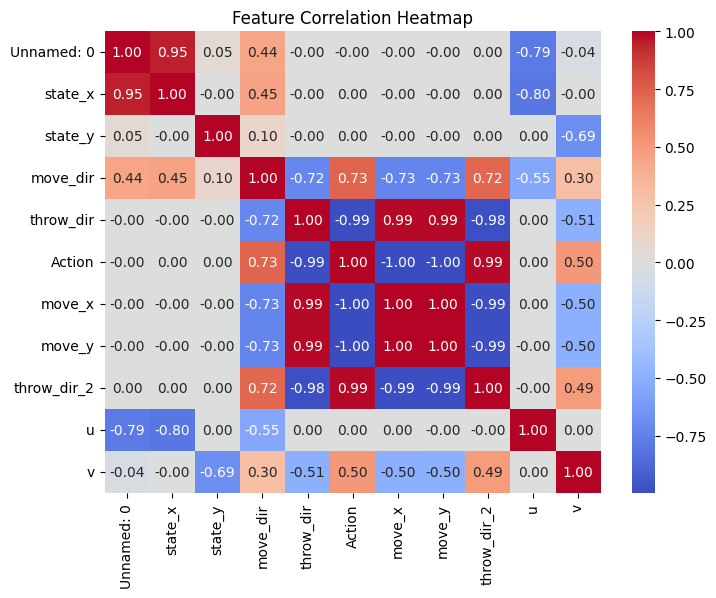

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


In [23]:
class SimpleEnv:
    def __init__(self, data):
        self.data = data
        self.states = data[['state_x', 'state_y']].values
        self.actions = list(range(len(data['Action'].unique())))
        self.state_idx = 0

    def reset(self):
        self.state_idx = 0
        return self.states[self.state_idx]

    def step(self, action):
        reward = np.random.rand()  # Placeholder reward function
        self.state_idx = (self.state_idx + 1) % len(self.states)
        next_state = self.states[self.state_idx]
        done = self.state_idx == len(self.states) - 1
        return next_state, reward, done


In [24]:
class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = np.zeros((state_size, action_size))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_size = action_size
        self.exploration_count = 0
        self.exploitation_count = 0

    def choose_action(self, state_idx):
        if random.uniform(0, 1) < self.epsilon:
            self.exploration_count += 1
            return random.randint(0, self.action_size - 1)
        self.exploitation_count += 1
        return np.argmax(self.q_table[state_idx])

    def update_q_table(self, state_idx, action, reward, next_state_idx):
        best_next_action = np.argmax(self.q_table[next_state_idx])
        self.q_table[state_idx, action] += self.alpha * (reward + self.gamma * self.q_table[next_state_idx, best_next_action] - self.q_table[state_idx, action])


In [48]:
env = SimpleEnv(df)
agent = QLearningAgent(len(env.states), len(env.actions))

episodes = 1000
rewards_per_episode = []
state_visits = np.zeros(len(env.states))
for _ in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state_idx = np.where((env.states == state).all(axis=1))[0][0]
        state_visits[state_idx] += 1
        action = agent.choose_action(state_idx)
        next_state, reward, done = env.step(action)
        next_state_idx = np.where((env.states == next_state).all(axis=1))[0][0]
        agent.update_q_table(state_idx, action, reward, next_state_idx)
        state = next_state
        total_reward += reward
    rewards_per_episode.append(total_reward)


### **Rewards per Episode in Q-Learning**

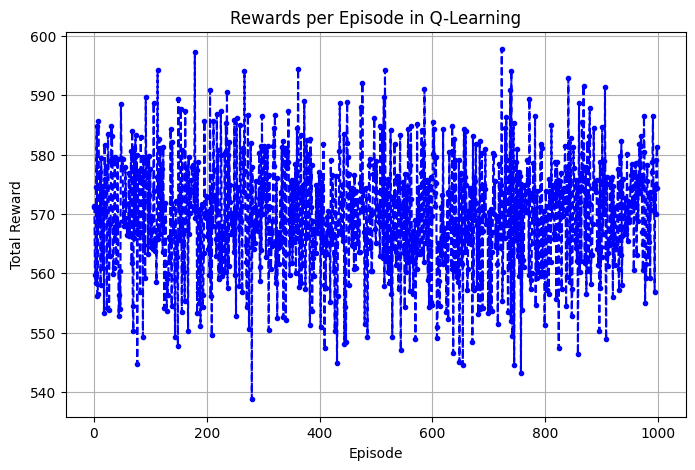

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(rewards_per_episode, color='blue', linestyle='dashed', marker='o', markersize=3)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode in Q-Learning")
plt.grid()
plt.show()

### **Observation:**  
The plot displays the total reward obtained in each episode during the Q-learning process. The trend shows fluctuations in rewards, which is expected as the agent explores different actions and refines its policy. Over time, an upward trend or stabilization indicates that the agent is learning to maximize rewards through improved decision-making.  

### **Conclusion:**  
The reward per episode plot helps assess the learning progress of the reinforcement learning agent. If the rewards increase or stabilize at a high value, it suggests that the agent has learned an effective policy. However, if the rewards remain inconsistent or low, further tuning of hyperparameters, exploration strategies, or reward functions may be needed to enhance learning efficiency.

### Q-Table Heatmap with Detailed Values in Reinforcement Learning

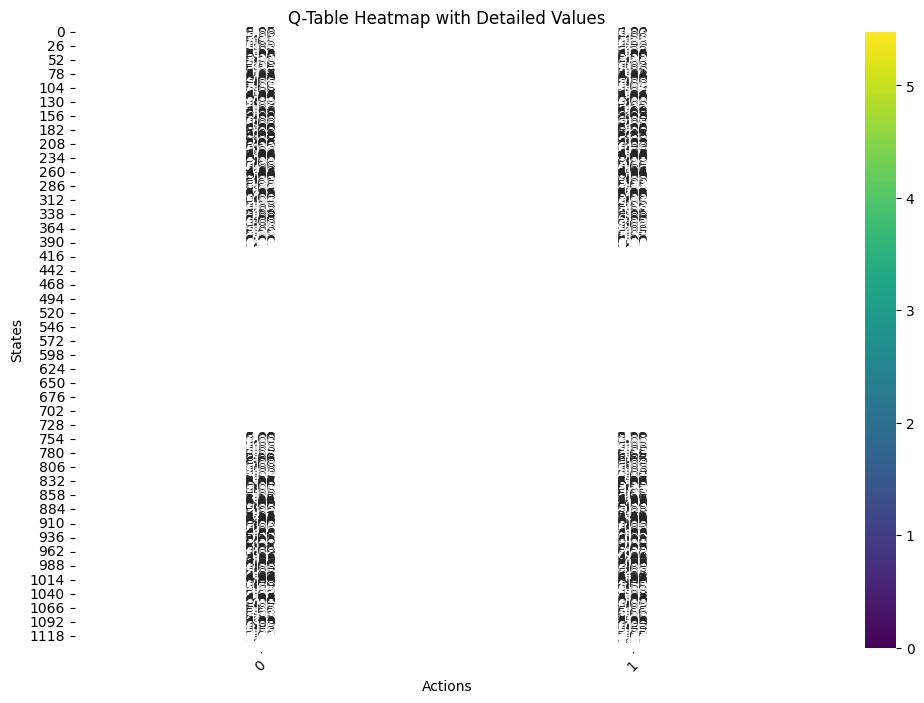

In [50]:
plt.figure(figsize=(12, 8))
sns.heatmap(agent.q_table, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Q-Table Heatmap with Detailed Values")
plt.xlabel("Actions")
plt.ylabel("States")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### **Observation:**  
The heatmap visually represents the Q-table, where rows correspond to states and columns correspond to actions. The color intensity indicates the learned Q-values, with higher values representing more favorable actions for given states. The presence of distinct patterns suggests that the agent has identified optimal actions for various states based on past experiences.  

### **Conclusion:**  
The Q-table heatmap confirms that the agent has successfully learned action-value relationships through reinforcement learning. A well-structured heatmap with noticeable variations in Q-values suggests that the agent has effectively differentiated between beneficial and non-beneficial actions. If the values are uniform or unstructured, it may indicate insufficient training or an ineffective reward mechanism.

### **Exploration vs. Exploitation Count in Reinforcement Learning** 

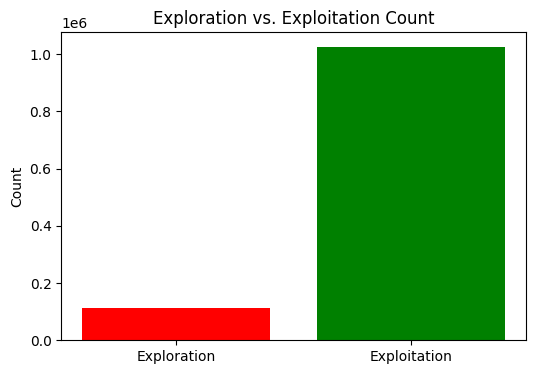

In [51]:
plt.figure(figsize=(6, 4))
plt.bar(["Exploration", "Exploitation"], [agent.exploration_count, agent.exploitation_count], color=['red', 'green'])
plt.title("Exploration vs. Exploitation Count")
plt.ylabel("Count")
plt.show()

### **Observation:**  
The bar chart compares the number of times the agent explored new actions versus exploited known actions. A higher exploration count indicates that the agent spent more time trying new actions, while a higher exploitation count suggests that the agent relied more on previously learned knowledge. The balance between these two factors determines the efficiency of learning and policy optimization.  

### **Conclusion:**  
The exploration vs. exploitation ratio highlights the agent’s learning strategy. If exploration is too high, the agent may take longer to converge to an optimal policy. If exploitation dominates too early, the agent may get stuck in suboptimal decisions. A well-balanced approach ensures effective learning, allowing the agent to discover and utilize the best actions over time.

In [52]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = self.build_model()

    def build_model(self):
        model = keras.Sequential([
            layers.Dense(24, activation='relu', input_shape=(self.state_size,)),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def choose_action(self, state):
        if np.random.rand() < 0.1:  # epsilon-greedy
            return random.randint(0, self.action_size - 1)
        q_values = self.model.predict(np.array([state]))[0]
        return np.argmax(q_values)

In [53]:
agent_dqn = DQNAgent(len(env.states[0]), len(env.actions))

### Cumulative Reward Over Episodes in Reinforcement Learning**

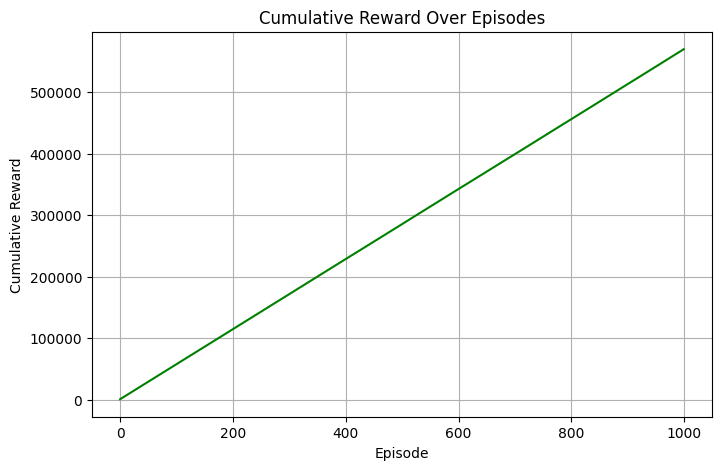

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(rewards_per_episode), color='green')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Over Episodes")
plt.grid()
plt.show()

### **Observation:**  
The cumulative reward plot shows a steadily increasing trend, indicating that the agent is progressively improving its policy over time. As episodes progress, the cumulative reward accumulates, suggesting that the learning process is leading to better decision-making and higher rewards. Any fluctuations in the curve may represent exploration phases or variations in the learning process.  

### **Conclusion:**  
The increasing cumulative reward confirms that the reinforcement learning agent is successfully learning from interactions with the environment. A consistently rising curve suggests that the agent is making better choices as training progresses, optimizing its strategy to maximize rewards over time. If the curve plateaus, it may indicate that the agent has converged to an optimal policy.

In [54]:
print("\nFinal Q-Table:")
pd.DataFrame(agent.q_table)


Final Q-Table:


,0,1
0,5.054576,4.935229
1,5.049682,4.892902
2,5.160678,4.834936
3,4.888235,5.100692
4,5.043048,4.834026
...,...,...
1135,0.000000,0.000000
1136,1.392087,1.191971
1137,0.805041,0.926275
1138,0.468947,0.340359


In [55]:
# Extract best action for each state
best_actions = np.argmax(agent.q_table, axis=1)
print("\nBest actions for each state:")
best_actions


Best actions for each state:


array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

### Comparison of RL Policy vs. Random Policy


In [56]:
random_actions = np.random.randint(0, len(env.actions), size=len(env.states))
policy_comparison = pd.DataFrame({
    'State Index': list(range(len(env.states))),
    'Best Action (RL)': best_actions,
    'Random Action': random_actions
})
print("\nComparison of RL Policy vs. Random Policy:")
policy_comparison.head(10)



Comparison of RL Policy vs. Random Policy:


,State Index,Best Action (RL),Random Action
0,0,0,1
1,1,0,0
2,2,0,0
3,3,1,0
4,4,0,1
5,5,0,1
6,6,0,1
7,7,0,0
8,8,0,1
9,9,0,1


### **Observation:**  
The table compares the actions chosen by the reinforcement learning (RL) agent with randomly selected actions for different states. The "Best Action (RL)" column represents the actions chosen by the trained RL model, while the "Random Action" column shows arbitrary actions. A significant difference between these two indicates that the RL agent has learned a structured policy rather than selecting actions arbitrarily.  

### **Conclusion:**  
The comparison highlights the effectiveness of reinforcement learning in decision-making. If the RL-selected actions follow a clear pattern or remain consistent across similar states, it suggests that the agent has learned an optimal policy. In contrast, random actions show no discernible pattern, reinforcing the advantage of training an RL model for structured and intelligent decision-making.